# Phase 4 Project Notebook
- Author: Jonathan Holt
- Data Science Flex

## Business Problem
- What are the top 5 best zip codes for us to invest in?

## Questions to Answer

1. What is the average (mean) home price for zip codes?
    a. also by: State, Metro Region, etc.
2. Which zip codes performed above expectations?
3. Do the top performing zip codes have any identifiers?


## What Models & Metrics I plan on using

## Helper Functions
- Functions provided by Flatiron

In [1]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [2]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    #melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted = pd.melt(df, id_vars=['ZipCode', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [3]:
#function for displaying money in millions.
def display_millions(x, pos):
    return '${:1.1f}M'.format(x*1e-6)

# PreProcessing

## Loading Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
pd.set_option('display.max_rows', 1500) #change the amount of rows displayed

pd.options.display.float_format = '{:,.2f}'.format 

In [5]:
ts = pd.read_csv("zillow_data.csv")
#ts = pd.read_csv('zillow_data.csv', index_col='Date')

In [6]:
ts.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,"334,200.00","335,400.00","336,500.00",...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,"235,700.00","236,900.00","236,700.00",...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,"210,400.00","212,200.00","212,200.00",...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,"498,100.00","500,900.00","503,100.00",...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,"77,300.00","77,300.00","77,300.00",...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


##  Changing RegionName to ZipCode
A google search shows that RegionName is the ZipCode for each Region. However, upon sorting, I discovered that any ZipCode beginning with a 0 was ignoring it and displaying as a 4 digit number. I will use the .str().zfill() method to ensure that all RegionNames are displaying the as 5 digits.

In [7]:
ts['RegionName'] = ts['RegionName'].astype(str).str.zfill(5)
ts.rename(columns={'RegionName': 'ZipCode'}, inplace=True)
ts.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,"334,200.00","335,400.00","336,500.00",...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,"235,700.00","236,900.00","236,700.00",...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,"210,400.00","212,200.00","212,200.00",...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,"498,100.00","500,900.00","503,100.00",...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,"77,300.00","77,300.00","77,300.00",...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Checking for Null Values

In [8]:
ts.isnull().sum()

RegionID         0
ZipCode          0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
1998-03       1036
1998-04       1036
1998-05       1036
1998-06       1036
1998-07       1036
1998-08       1036
1998-09       1036
1998-10       1036
1998-11       1036
1998-12       1036
1999-01       1036
1999-02       1036
1999-03       1036
1999-04       1036
1999-05       1036
1999-06       1036
1999-07       1036
1999-08       1036
1999-09       1036
1999-10       1036
1999-11       1036
1999-12       1036
2000-01     

### Analysis
There are many Null Values. 
- For categorical data, 7% of Metro are null (1043 of 14,723).
- Dates from 1996 - mid 2003, also have 7% null values.
- Then it starts to get better. 6% null and decreasing.

What is my decision on null values?
- keep?
- delete?
- change (mean)?

### Metro
- The null values for Metro are because of rural zip codes that aren't close enough to a metro area to be classified as such. I will create a new value for Metro of 'no_metro' to represent these rural zip codes. 
- NOTE: for any analysis of Metro areas, 'no_metro' should be excluded as these zip codes are NOT part of the same area.

In [9]:
ts['Metro'].value_counts()

New York                              779
Los Angeles-Long Beach-Anaheim        347
Chicago                               325
Philadelphia                          281
Washington                            249
Boston                                246
Dallas-Fort Worth                     217
Minneapolis-St Paul                   201
Houston                               187
Pittsburgh                            177
Miami-Fort Lauderdale                 162
Portland                              161
Detroit                               153
Atlanta                               152
Seattle                               141
St. Louis                             140
San Francisco                         134
Kansas City                           127
Phoenix                               126
Baltimore                             122
Tampa                                 118
Riverside                             116
Cincinnati                            109
Denver                            

In [10]:
ts['Metro'].fillna('no_metro', inplace=True)

In [11]:
ts['Metro'].value_counts()

no_metro                              1043
New York                               779
Los Angeles-Long Beach-Anaheim         347
Chicago                                325
Philadelphia                           281
Washington                             249
Boston                                 246
Dallas-Fort Worth                      217
Minneapolis-St Paul                    201
Houston                                187
Pittsburgh                             177
Miami-Fort Lauderdale                  162
Portland                               161
Detroit                                153
Atlanta                                152
Seattle                                141
St. Louis                              140
San Francisco                          134
Kansas City                            127
Phoenix                                126
Baltimore                              122
Tampa                                  118
Riverside                              116
Cincinnati 

In [12]:
ts.isna().sum()

RegionID         0
ZipCode          0
City             0
State            0
Metro            0
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
1998-03       1036
1998-04       1036
1998-05       1036
1998-06       1036
1998-07       1036
1998-08       1036
1998-09       1036
1998-10       1036
1998-11       1036
1998-12       1036
1999-01       1036
1999-02       1036
1999-03       1036
1999-04       1036
1999-05       1036
1999-06       1036
1999-07       1036
1999-08       1036
1999-09       1036
1999-10       1036
1999-11       1036
1999-12       1036
2000-01     

- All remaining null values are for the time series data. I will leave them as is for now, and deal with them later on as it will likely depend on how I am grouping the data, etc.

### Changing dtype for all housing data to float.

In [45]:
ts[ts.columns[7:]] = ts[ts.columns[7:]].astype(float)

## Creating avg_home_df
- Create Dataset that is just the mean values to do analysis of trends, etc for baseline.
- then I can look for zip codes that have the best performance above and beyong baseline.

In [13]:
#ts_value = ts.drop(columns=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'])
#avg_home_ts = ts_value.reset_index()
#avg_home_ts['time'] = pd.to_datetime(avg_home_ts['index'])
#avg_home_ts.set_index('time', inplace=True)
#avg_home_ts.rename(columns={0: 'home_value'}, inplace=True)
#avg_home_ts.drop(columns=('index'), inplace=True)
#avg_home_ts.head()

In [14]:
#df_values = ts.drop(columns=['RegionID', 'ZipCode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'])

In [46]:
data_values = ts.iloc[:, 7:]

In [47]:
data_values['2018-04'].dtype

dtype('float64')

In [17]:
avg_home_df = pd.DataFrame(data_values.mean())

In [18]:
avg_home_df.head()

,0
1996-04,"118,299.12"
1996-05,"118,419.04"
1996-06,"118,537.42"
1996-07,"118,653.07"
1996-08,"118,780.25"


In [19]:
avg_home_df = avg_home_df.reset_index()
avg_home_df['time'] = pd.to_datetime(avg_home_df['index'])
avg_home_df.head()

,index,0,time
0,1996-04,"118,299.12",1996-04-01
1,1996-05,"118,419.04",1996-05-01
2,1996-06,"118,537.42",1996-06-01
3,1996-07,"118,653.07",1996-07-01
4,1996-08,"118,780.25",1996-08-01


In [20]:
avg_home_df.set_index('time', inplace=True)

In [21]:
avg_home_df.head()

,index,0
time,,
1996-04-01,1996-04,"118,299.12"
1996-05-01,1996-05,"118,419.04"
1996-06-01,1996-06,"118,537.42"
1996-07-01,1996-07,"118,653.07"
1996-08-01,1996-08,"118,780.25"


In [22]:
avg_home_df.rename(columns={0: 'home_value'}, inplace=True)

In [23]:
avg_home_df.drop(columns=('index'), inplace=True)

In [24]:
avg_home_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   home_value  265 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


In [25]:
avg_home_df

,home_value
time,
1996-04-01,"118,299.12"
1996-05-01,"118,419.04"
1996-06-01,"118,537.42"
1996-07-01,"118,653.07"
1996-08-01,"118,780.25"
1996-09-01,"118,927.53"
1996-10-01,"119,120.52"
1996-11-01,"119,345.35"
1996-12-01,"119,685.08"


In [26]:
avg_home_df.index[0].year

1996

## Analysis of Avg_Home_DF

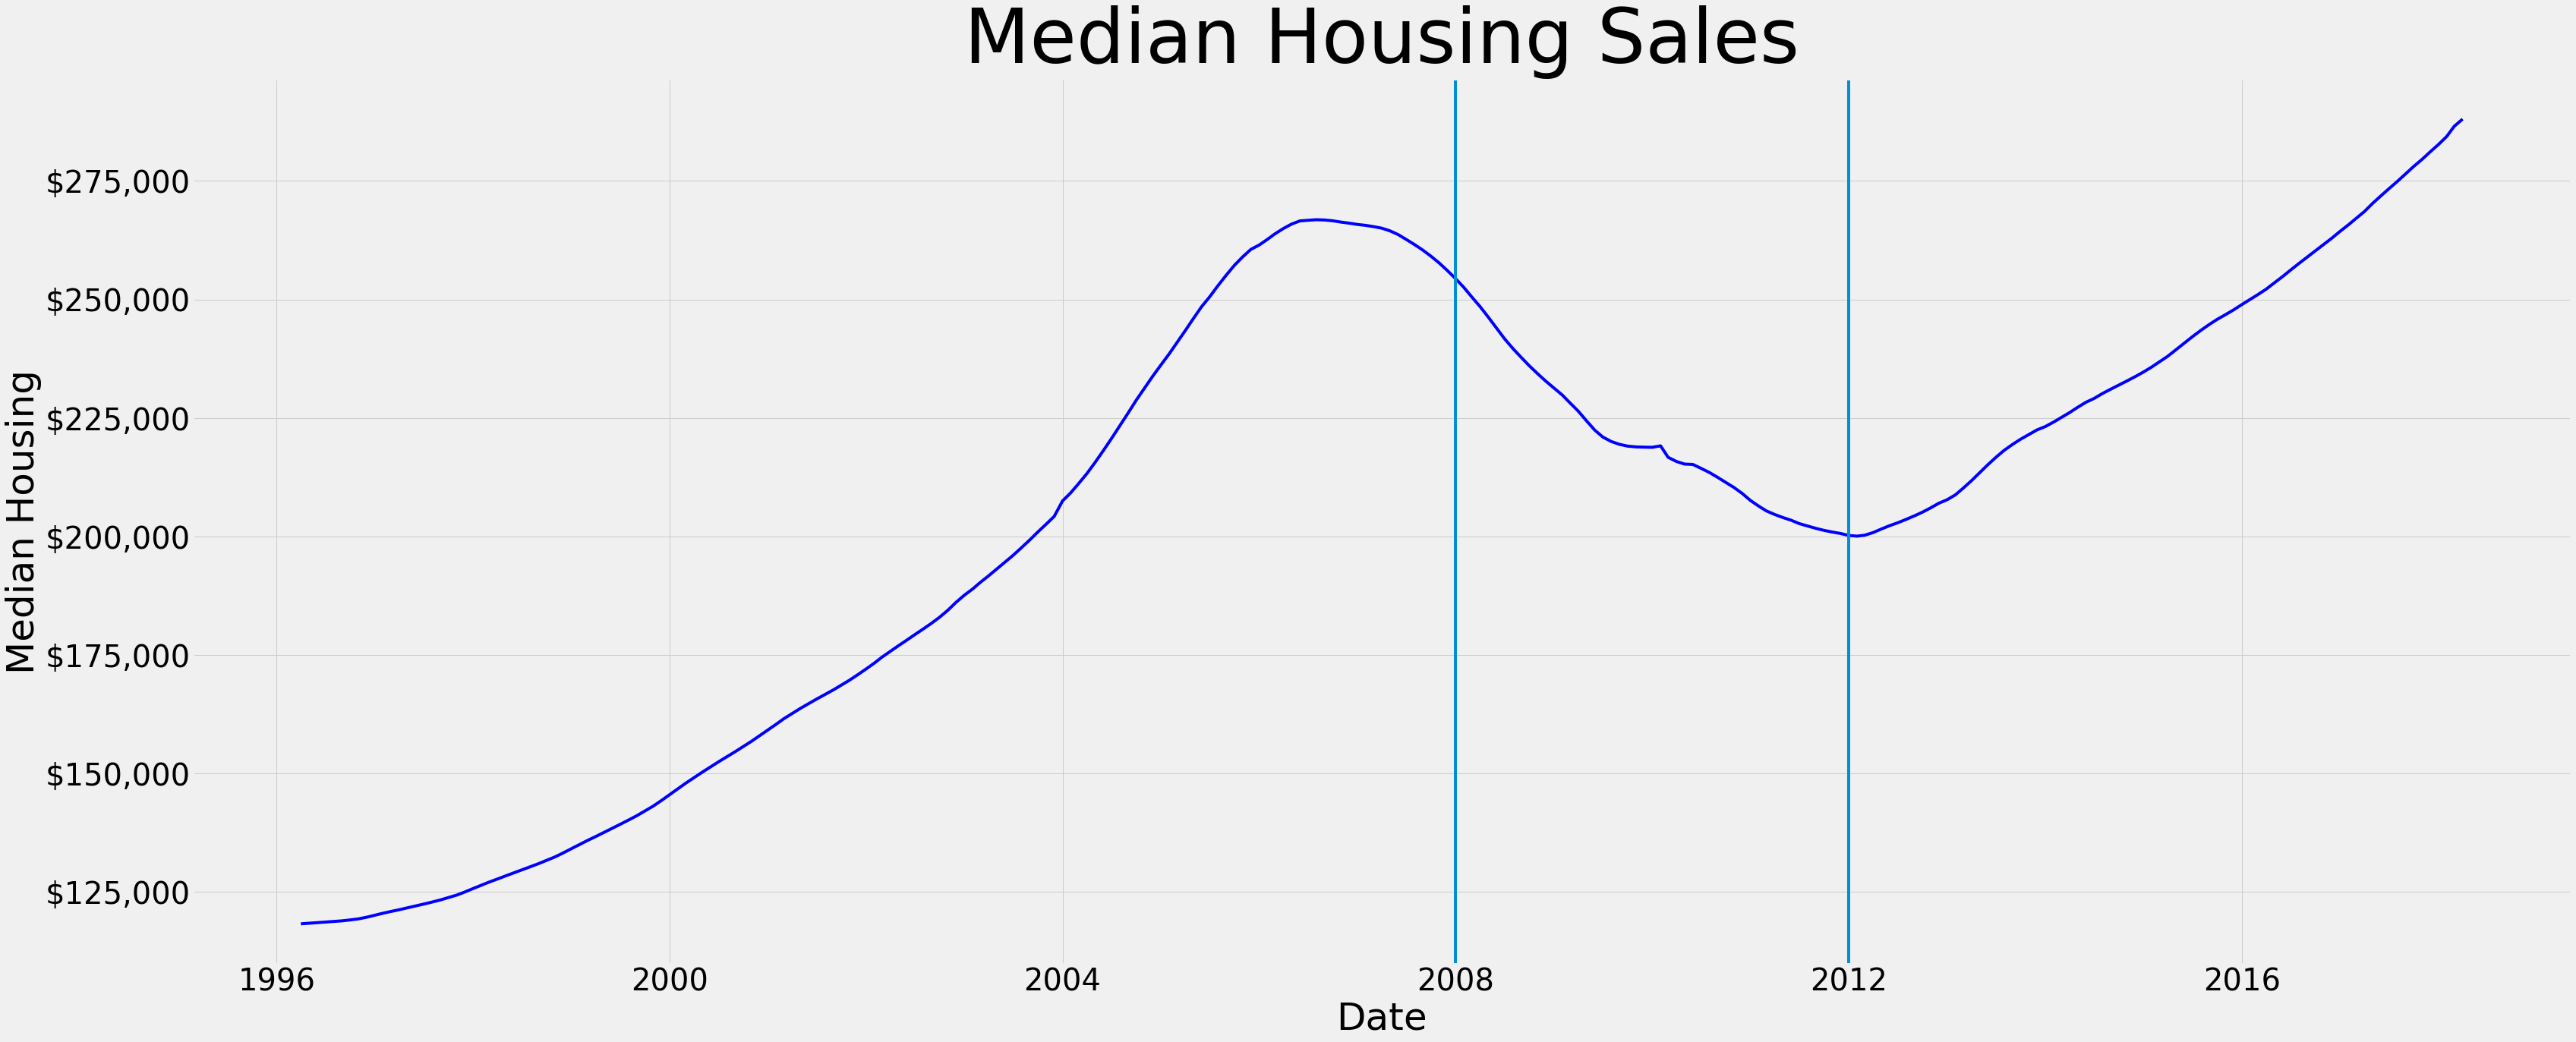

In [28]:
fig, ax = plt.subplots(figsize=(50, 20))
p = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='blue');

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

y1 = p.axvline('2008-01') #housing market crash begins
y2 = p.axvline('2012-01') #housing market crash ends
#ax.fill_between(y1, y2)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

## Analysis:
- Home Sales Values are on an upward trend, however there was a significant dip from aprox 2006 - 2012, before recovering and trending upward again.
- The dip was due to the US Housing Market Crash of 2008. (https://en.wikipedia.org/wiki/United_States_housing_bubble)

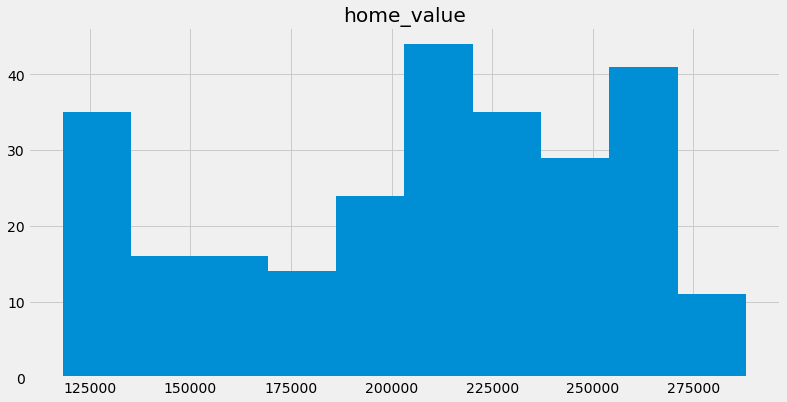

In [29]:
avg_home_df.hist(figsize = (12,6))
plt.show()

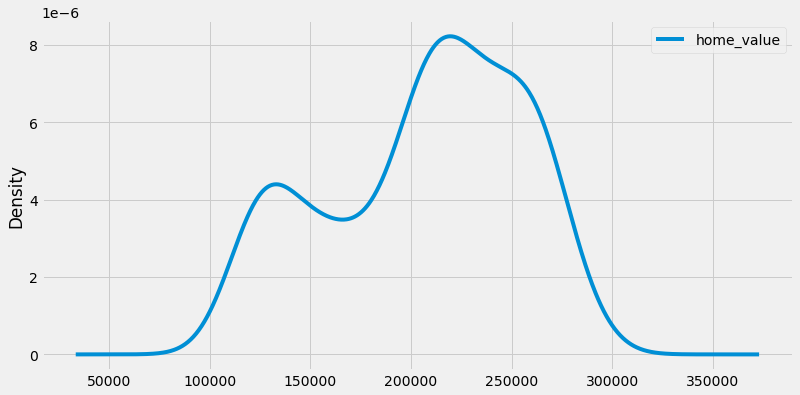

In [30]:
avg_home_df.plot(kind='kde', figsize = (12,6))
plt.show()

In [ ]:
# Determine rolling statistics
#roll_mean = avg_home_df.rolling(window=12, center=False).mean()
#roll_std = avg_home_df.rolling(window=12, center=False).std()

In [ ]:
#fig, ax = plt.subplots(figsize=(30, 20))
#p = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='blue', label='Original');

#plt.plot(roll_mean, color='red', label='Rolling Mean')
#plt.plot(roll_std, color='black', label = 'Rolling Std')

#p.set_xlabel("Date", fontsize = 25)
#p.set_ylabel("Median Housing", fontsize = 25)

#plt.xticks(fontsize=40)
#plt.yticks(fontsize=40)

#fmt = '${x:,.0f}'
#tick = mtick.StrMethodFormatter(fmt)
#ax.yaxis.set_major_formatter(tick) 

#p.set_title("Median Housing Sales", fontsize = 50)
#plt.figsize=(50,25)
#plt.legend(loc='best')


#plt.show();

## Dickey Fuller Test

In [31]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
#dftest = adfuller(data['#Passengers'])
dftest = adfuller(avg_home_df)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                 -1.89
p-value                         0.34
#Lags Used                      2.00
Number of Observations Used   262.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


# Feature Engineering

- I want to add additional features to the DataSet so that I can determine what data I want to analyze further and ultimately model.
- add: Region Mean, Region Growth, etc
- THE POINT IS TO IDENTIFY WHICH ZIPS ARE THE BEST PERFORMING SO I CAN NARROW DOWN THE DATA TO CAPTURE!!!!

In [ ]:
#ts.head()

In [48]:
new_df = ts.copy()

In [49]:
new_df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,"334,200.00","335,400.00","336,500.00",...,"1,005,500.00","1,007,500.00","1,007,800.00","1,009,600.00","1,013,300.00","1,018,700.00","1,024,400.00","1,030,700.00","1,033,800.00","1,030,600.00"
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,"235,700.00","236,900.00","236,700.00",...,"308,000.00","310,000.00","312,500.00","314,100.00","315,000.00","316,600.00","318,100.00","319,600.00","321,100.00","321,800.00"
2,91982,77494,Katy,TX,Houston,Harris,3,"210,400.00","212,200.00","212,200.00",...,"321,000.00","320,600.00","320,200.00","320,400.00","320,800.00","321,200.00","321,200.00","323,000.00","326,900.00","329,900.00"
3,84616,60614,Chicago,IL,Chicago,Cook,4,"498,100.00","500,900.00","503,100.00",...,"1,289,800.00","1,287,700.00","1,287,400.00","1,291,500.00","1,296,600.00","1,299,000.00","1,302,700.00","1,306,400.00","1,308,500.00","1,307,000.00"
4,93144,79936,El Paso,TX,El Paso,El Paso,5,"77,300.00","77,300.00","77,300.00",...,"119,100.00","119,400.00","120,000.00","120,300.00","120,300.00","120,300.00","120,300.00","120,500.00","121,000.00","121,500.00"


In [50]:
new_df['2018-04'].dtype

dtype('float64')

In [51]:
new_df['mean'] = data_values.apply(lambda x: x.mean(), axis=1)

In [52]:
new_df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,mean
0,84654,60657,Chicago,IL,Chicago,Cook,1,"334,200.00","335,400.00","336,500.00",...,"1,007,500.00","1,007,800.00","1,009,600.00","1,013,300.00","1,018,700.00","1,024,400.00","1,030,700.00","1,033,800.00","1,030,600.00","743,978.87"
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,"235,700.00","236,900.00","236,700.00",...,"310,000.00","312,500.00","314,100.00","315,000.00","316,600.00","318,100.00","319,600.00","321,100.00","321,800.00","219,655.85"
2,91982,77494,Katy,TX,Houston,Harris,3,"210,400.00","212,200.00","212,200.00",...,"320,600.00","320,200.00","320,400.00","320,800.00","321,200.00","321,200.00","323,000.00","326,900.00","329,900.00","262,110.57"
3,84616,60614,Chicago,IL,Chicago,Cook,4,"498,100.00","500,900.00","503,100.00",...,"1,287,700.00","1,287,400.00","1,291,500.00","1,296,600.00","1,299,000.00","1,302,700.00","1,306,400.00","1,308,500.00","1,307,000.00","974,139.25"
4,93144,79936,El Paso,TX,El Paso,El Paso,5,"77,300.00","77,300.00","77,300.00",...,"119,400.00","120,000.00","120,300.00","120,300.00","120,300.00","120,300.00","120,500.00","121,000.00","121,500.00","101,875.47"


In [ ]:
#total_df = new_df.copy()
#last_5_years = 

In [ ]:
#new_df['min'] = data_values.apply(lambda x: x.min(), axis=1)

In [ ]:
#new_df['max'] = data_values.apply(lambda x: x.max(), axis=1)

In [54]:
#new_df['mean'] = data_values.apply(lambda x: x.mean(), axis=1)
#new_df['delta'] = new_df.apply(lambda x: x['2018-04'] - x['min'], axis=1)
#new_df['delta_percent'] = new_df.apply(lambda x: x['delta'] / x['min'], axis=1)

In [ ]:
new_df.head()

In [ ]:
new_df.sort_values('delta_percent', ascending=False).head(500)

In [ ]:
new_df.iloc[117]

# Analysis of New_df

## Top Zip Codes by Mean Value

In [ ]:
#new_df.sort_values('mean', ascending=True).head(10)

In [ ]:
#new_df.sort_values('delta', ascending=False).head(10)

# Getting Recent Data (last 5 years)

In [55]:
recent_data = data_values.iloc[:, -64:]

In [56]:
recent_data.head()

,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,"802,300.00","806,100.00","810,900.00","817,400.00","826,800.00","837,900.00","848,100.00","853,800.00","856,700.00","856,600.00",...,"1,005,500.00","1,007,500.00","1,007,800.00","1,009,600.00","1,013,300.00","1,018,700.00","1,024,400.00","1,030,700.00","1,033,800.00","1,030,600.00"
1,"205,900.00","206,900.00","208,500.00","209,800.00","211,300.00","214,000.00","217,200.00","220,600.00","223,800.00","226,500.00",...,"308,000.00","310,000.00","312,500.00","314,100.00","315,000.00","316,600.00","318,100.00","319,600.00","321,100.00","321,800.00"
2,"256,900.00","256,800.00","256,700.00","257,100.00","258,300.00","260,700.00","263,900.00","267,000.00","269,200.00","271,000.00",...,"321,000.00","320,600.00","320,200.00","320,400.00","320,800.00","321,200.00","321,200.00","323,000.00","326,900.00","329,900.00"
3,"1,006,300.00","1,013,700.00","1,024,800.00","1,038,300.00","1,053,900.00","1,070,600.00","1,089,900.00","1,108,100.00","1,123,700.00","1,135,100.00",...,"1,289,800.00","1,287,700.00","1,287,400.00","1,291,500.00","1,296,600.00","1,299,000.00","1,302,700.00","1,306,400.00","1,308,500.00","1,307,000.00"
4,"113,000.00","113,300.00","113,600.00","113,500.00","113,300.00","113,000.00","113,000.00","112,900.00","112,800.00","112,500.00",...,"119,100.00","119,400.00","120,000.00","120,300.00","120,300.00","120,300.00","120,300.00","120,500.00","121,000.00","121,500.00"


In [57]:
new_df['5_yr_mean'] = recent_data.apply(lambda x: x.mean(), axis=1)

In [ ]:
#new_df['last_5_delta'] = recent_data.apply(lambda x: x['2018-04'] - x['2013-01'], axis=1)

In [58]:
new_df['5_yr_ROI'] = new_df.apply(lambda x: x['2018-04'] - x['2013-01'], axis=1)

In [59]:
new_df['5_yr_ROI%'] = new_df.apply(lambda x: x['5_yr_ROI'] / x['2013-01'], axis=1)

In [60]:
new_df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,mean,5_yr_mean,5_yr_ROI,5_yr_ROI%
0,84654,60657,Chicago,IL,Chicago,Cook,1,"334,200.00","335,400.00","336,500.00",...,"1,013,300.00","1,018,700.00","1,024,400.00","1,030,700.00","1,033,800.00","1,030,600.00","743,978.87","929,381.25","228,300.00",0.28
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,"235,700.00","236,900.00","236,700.00",...,"315,000.00","316,600.00","318,100.00","319,600.00","321,100.00","321,800.00","219,655.85","267,568.75","115,900.00",0.56
2,91982,77494,Katy,TX,Houston,Harris,3,"210,400.00","212,200.00","212,200.00",...,"320,800.00","321,200.00","321,200.00","323,000.00","326,900.00","329,900.00","262,110.57","304,398.44","73,000.00",0.28
3,84616,60614,Chicago,IL,Chicago,Cook,4,"498,100.00","500,900.00","503,100.00",...,"1,296,600.00","1,299,000.00","1,302,700.00","1,306,400.00","1,308,500.00","1,307,000.00","974,139.25","1,201,653.12","300,700.00",0.30
4,93144,79936,El Paso,TX,El Paso,El Paso,5,"77,300.00","77,300.00","77,300.00",...,"120,300.00","120,300.00","120,300.00","120,500.00","121,000.00","121,500.00","101,875.47","115,440.62","8,500.00",0.08


In [61]:
new_df.sort_values('5_yr_ROI%', ascending=False).head(10)

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,mean,5_yr_mean,5_yr_ROI,5_yr_ROI%
1477,97803,94601,Oakland,CA,San Francisco,Alameda,1478,"114,600.00","114,500.00","114,500.00",...,"526,700.00","535,800.00","546,900.00","555,000.00","562,000.00","566,700.00","284,443.40","376,948.44","373,000.00",1.93
7302,93292,80216,Denver,CO,Denver,Denver,7303,nan,nan,nan,...,"249,100.00","251,200.00","253,800.00","258,100.00","263,700.00","267,300.00","174,928.12","174,928.12","175,500.00",1.91
1239,97795,94590,Vallejo,CA,Vallejo,Solano,1240,"108,200.00","107,800.00","107,500.00",...,"351,200.00","357,100.00","362,500.00","366,900.00","371,600.00","376,100.00","225,785.28","253,175.00","241,000.00",1.78
2627,72619,33460,Lake Worth,FL,Miami-Fort Lauderdale,Palm Beach,2628,"59,800.00","59,900.00","60,000.00",...,"202,600.00","206,000.00","209,600.00","211,600.00","213,300.00","215,600.00","127,891.32","143,490.62","138,000.00",1.78
2661,72768,33705,Saint Petersburg,FL,Tampa,Pinellas,2662,"54,600.00","54,800.00","55,000.00",...,"165,300.00","167,100.00","168,200.00","171,100.00","175,100.00","177,300.00","99,316.23","109,917.19","112,300.00",1.73
5830,79095,48240,Redford,MI,Detroit,Wayne,5831,"67,800.00","68,200.00","68,500.00",...,"69,700.00","71,000.00","72,300.00","73,500.00","75,300.00","76,800.00","78,767.92","52,610.94","48,400.00",1.70
6105,74241,37210,Nashville,TN,Nashville,Davidson,6106,"60,800.00","61,000.00","61,200.00",...,"214,500.00","217,200.00","219,300.00","221,500.00","224,300.00","226,500.00","97,483.77","141,571.88","141,900.00",1.68
1758,71036,30316,Atlanta,GA,Atlanta,Fulton,1759,"62,300.00","62,300.00","62,300.00",...,"255,300.00","258,800.00","261,600.00","264,300.00","268,700.00","272,500.00","143,101.51","190,731.25","168,400.00",1.62
1273,72601,33435,Boynton Beach,FL,Miami-Fort Lauderdale,Palm Beach,1274,"72,700.00","72,900.00","73,000.00",...,"206,200.00","207,000.00","207,500.00","209,100.00","212,200.00","214,900.00","132,937.74","145,817.19","132,800.00",1.62
4298,98433,95824,Sacramento,CA,Sacramento,Sacramento,4299,"73,800.00","73,400.00","73,000.00",...,"215,900.00","218,400.00","221,400.00","223,500.00","224,700.00","224,700.00","138,699.25","160,762.50","138,800.00",1.62


In [62]:
new_df.sort_values('5_yr_ROI', ascending=False).head(10)

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,mean,5_yr_mean,5_yr_ROI,5_yr_ROI%
272,61635,10021,New York,NY,New York,New York,273,nan,nan,nan,...,"18,428,800.00","18,307,100.00","18,365,900.00","18,530,400.00","18,337,700.00","17,894,900.00","12,854,267.44","16,281,670.31","6,743,900.00",0.60
20,61625,10011,New York,NY,New York,New York,21,nan,nan,nan,...,"12,016,300.00","11,946,500.00","11,978,100.00","11,849,300.00","11,563,000.00","11,478,300.00","7,755,843.75","10,555,268.75","3,592,300.00",0.46
10237,97518,94027,Atherton,CA,San Francisco,San Mateo,10238,"1,179,200.00","1,184,300.00","1,189,700.00",...,"6,429,100.00","6,581,800.00","6,705,000.00","6,764,600.00","6,788,400.00","6,796,500.00","3,487,129.06","5,228,923.44","3,043,400.00",0.81
4816,96086,90210,Beverly Hills,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,4817,"1,015,400.00","1,016,900.00","1,018,400.00",...,"5,574,100.00","5,661,000.00","5,738,200.00","5,816,100.00","5,907,800.00","5,956,700.00","2,789,977.36","4,501,590.62","2,775,500.00",0.87
5738,97691,94301,Palo Alto,CA,San Jose,Santa Clara,5739,"709,500.00","711,900.00","715,000.00",...,"4,481,700.00","4,544,700.00","4,595,100.00","4,668,700.00","4,762,600.00","4,818,400.00","2,084,380.38","3,590,104.69","2,282,000.00",0.90
5843,97513,94022,Los Altos,CA,San Jose,Santa Clara,5844,"795,600.00","798,400.00","801,700.00",...,"4,045,200.00","4,118,000.00","4,170,500.00","4,235,700.00","4,321,900.00","4,372,600.00","2,066,817.74","3,244,868.75","2,040,600.00",0.88
21,61703,10128,New York,NY,New York,New York,22,"3,676,700.00","3,704,200.00","3,729,600.00",...,"7,371,400.00","7,342,700.00","7,353,300.00","7,350,300.00","7,363,000.00","7,386,600.00","5,085,435.85","6,953,489.06","2,008,600.00",0.37
4723,72636,33480,Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,4724,"958,400.00","958,100.00","957,900.00",...,"4,588,200.00","4,609,000.00","4,626,500.00","4,661,200.00","4,692,300.00","4,686,200.00","2,634,498.11","3,805,860.94","1,890,300.00",0.68
1534,62028,11217,New York,NY,New York,Kings,1535,nan,nan,nan,...,"3,407,000.00","3,404,100.00","3,413,800.00","3,482,900.00","3,588,100.00","3,656,000.00","1,977,406.98","2,819,290.62","1,819,800.00",0.99
508,61628,10014,New York,NY,New York,New York,509,nan,nan,nan,...,"9,515,800.00","9,492,800.00","9,524,900.00","9,373,400.00","9,119,600.00","8,959,300.00","6,836,902.33","9,151,843.75","1,781,600.00",0.25


# Recent Data (5 Year) Analysis

In [63]:
new_df.head(1)

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,mean,5_yr_mean,5_yr_ROI,5_yr_ROI%
0,84654,60657,Chicago,IL,Chicago,Cook,1,"334,200.00","335,400.00","336,500.00",...,"1,013,300.00","1,018,700.00","1,024,400.00","1,030,700.00","1,033,800.00","1,030,600.00","743,978.87","929,381.25","228,300.00",0.28


In [64]:
recent_df_5 = new_df[['ZipCode', 'City', 'State', 'CountyName', '2013-01', '2018-04', '5_yr_mean',
                    '5_yr_ROI', '5_yr_ROI%']]

In [65]:
recent_df_5.head()

,ZipCode,City,State,CountyName,2013-01,2018-04,5_yr_mean,5_yr_ROI,5_yr_ROI%
0,60657,Chicago,IL,Cook,"802,300.00","1,030,600.00","929,381.25","228,300.00",0.28
1,75070,McKinney,TX,Collin,"205,900.00","321,800.00","267,568.75","115,900.00",0.56
2,77494,Katy,TX,Harris,"256,900.00","329,900.00","304,398.44","73,000.00",0.28
3,60614,Chicago,IL,Cook,"1,006,300.00","1,307,000.00","1,201,653.12","300,700.00",0.30
4,79936,El Paso,TX,El Paso,"113,000.00","121,500.00","115,440.62","8,500.00",0.08


In [66]:
recent_df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ZipCode     14723 non-null  object 
 1   City        14723 non-null  object 
 2   State       14723 non-null  object 
 3   CountyName  14723 non-null  object 
 4   2013-01     14572 non-null  float64
 5   2018-04     14723 non-null  float64
 6   5_yr_mean   14723 non-null  float64
 7   5_yr_ROI    14572 non-null  float64
 8   5_yr_ROI%   14572 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.0+ MB


In [67]:
recent_df_5.sort_values('5_yr_ROI', ascending=False)

,ZipCode,City,State,CountyName,2013-01,2018-04,5_yr_mean,5_yr_ROI,5_yr_ROI%
272,10021,New York,NY,New York,"11,151,000.00","17,894,900.00","16,281,670.31","6,743,900.00",0.60
20,10011,New York,NY,New York,"7,886,000.00","11,478,300.00","10,555,268.75","3,592,300.00",0.46
10237,94027,Atherton,CA,San Mateo,"3,753,100.00","6,796,500.00","5,228,923.44","3,043,400.00",0.81
4816,90210,Beverly Hills,CA,Los Angeles,"3,181,200.00","5,956,700.00","4,501,590.62","2,775,500.00",0.87
5738,94301,Palo Alto,CA,Santa Clara,"2,536,400.00","4,818,400.00","3,590,104.69","2,282,000.00",0.90
...,...,...,...,...,...,...,...,...,...
14577,62440,Lerna,IL,Coles,nan,"90,900.00","77,897.83",nan,nan
14587,37141,Orlinda,TN,Robertson,nan,"180,700.00","144,831.03",nan,nan
14623,43013,Hartford,OH,Licking,nan,"208,400.00","210,428.85",nan,nan
14707,28039,East Spencer,NC,Rowan,nan,"28,300.00","28,280.43",nan,nan


In [89]:
recent_df_5.sort_values('5_yr_ROI%', ascending=False).head(10)

,ZipCode,City,State,CountyName,2013-01,2018-04,5_yr_mean,5_yr_ROI,5_yr_ROI%
1477,94601,Oakland,CA,Alameda,"193,700.00","566,700.00","376,948.44","373,000.00",1.93
7302,80216,Denver,CO,Denver,"91,800.00","267,300.00","174,928.12","175,500.00",1.91
1239,94590,Vallejo,CA,Solano,"135,100.00","376,100.00","253,175.00","241,000.00",1.78
2627,33460,Lake Worth,FL,Palm Beach,"77,600.00","215,600.00","143,490.62","138,000.00",1.78
2661,33705,Saint Petersburg,FL,Pinellas,"65,000.00","177,300.00","109,917.19","112,300.00",1.73
5830,48240,Redford,MI,Wayne,"28,400.00","76,800.00","52,610.94","48,400.00",1.70
6105,37210,Nashville,TN,Davidson,"84,600.00","226,500.00","141,571.88","141,900.00",1.68
1758,30316,Atlanta,GA,Fulton,"104,100.00","272,500.00","190,731.25","168,400.00",1.62
1273,33435,Boynton Beach,FL,Palm Beach,"82,100.00","214,900.00","145,817.19","132,800.00",1.62
4298,95824,Sacramento,CA,Sacramento,"85,900.00","224,700.00","160,762.50","138,800.00",1.62


# Melting top zipcodes

In [69]:
test_data = ts[ts['ZipCode'] == '94601']

In [70]:
zip_94601_ts = melt_data(test_data)

In [71]:
zip_94601_ts

,value
time,
1996-04-01,"114,600.00"
1996-05-01,"114,500.00"
1996-06-01,"114,500.00"
1996-07-01,"114,400.00"
1996-08-01,"114,400.00"
1996-09-01,"114,400.00"
1996-10-01,"114,400.00"
1996-11-01,"114,400.00"
1996-12-01,"114,500.00"


In [72]:
jon_test = zip_94601_ts

In [73]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
#dftest = adfuller(data['#Passengers'])
dftest = adfuller(jon_test)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                 -2.05
p-value                         0.27
#Lags Used                     15.00
Number of Observations Used   249.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [86]:
data = ts[ts['ZipCode'] == '80216']
melted_data = melt_data(data)
zip_80216_ts = melted_data
zip_80216_ts.head()

,value
time,
2013-01-01,"91,800.00"
2013-02-01,"93,300.00"
2013-03-01,"95,000.00"
2013-04-01,"97,600.00"
2013-05-01,"100,900.00"


In [90]:
data = ts[ts['ZipCode'] == '94590']
melted_data = melt_data(data)
zip_94590_ts = melted_data
zip_94590_ts.head()

,value
time,
1996-04-01,"108,200.00"
1996-05-01,"107,800.00"
1996-06-01,"107,500.00"
1996-07-01,"107,300.00"
1996-08-01,"107,100.00"


In [92]:
data = ts[ts['ZipCode'] == '33460']
melted_data = melt_data(data)
zip_33460_ts = melted_data
zip_33460_ts.head()

,value
time,
1996-04-01,"59,800.00"
1996-05-01,"59,900.00"
1996-06-01,"60,000.00"
1996-07-01,"60,200.00"
1996-08-01,"60,400.00"


# Visual: Comparing top Zips to national average

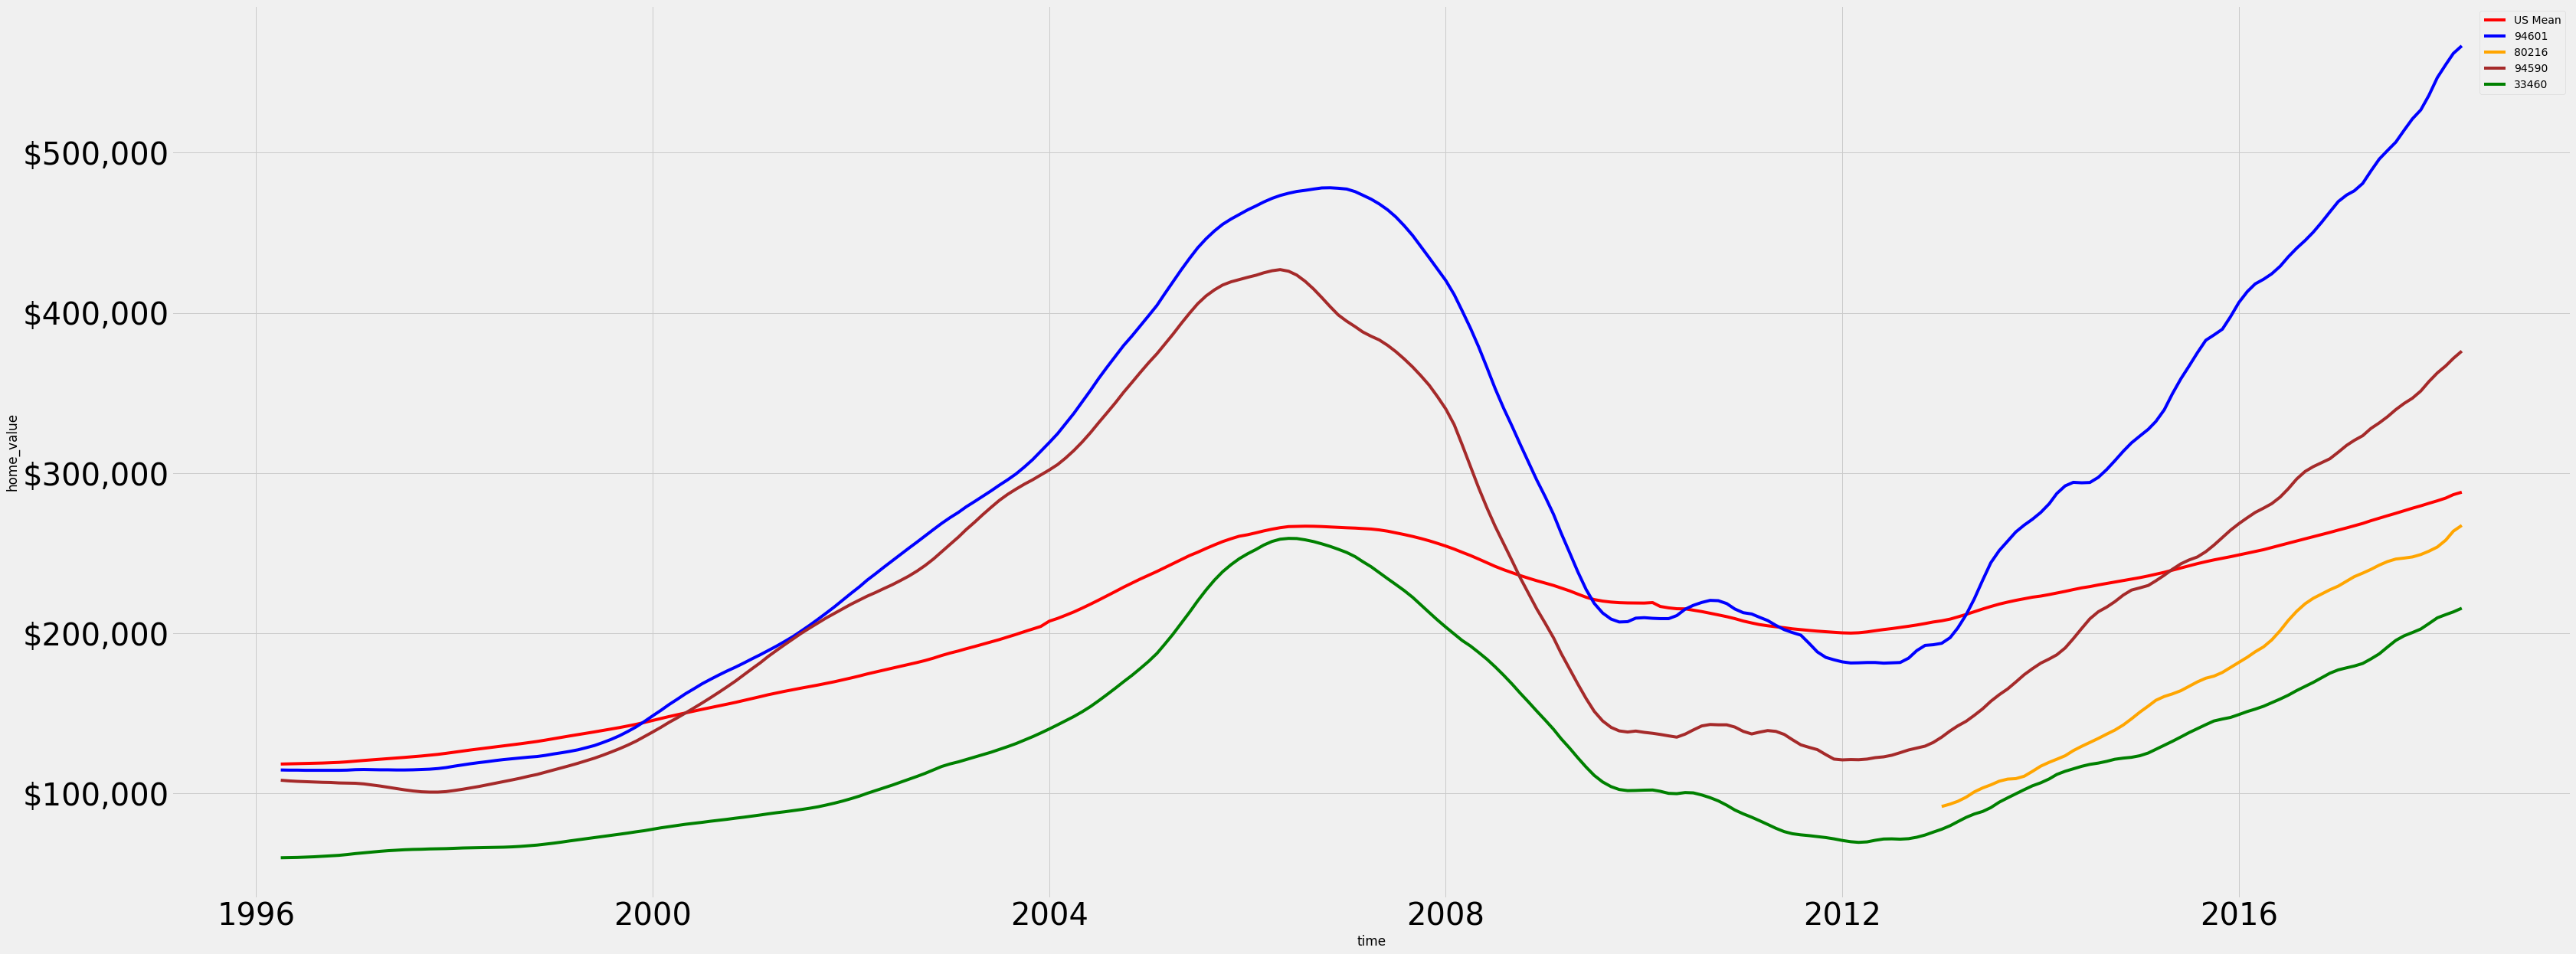

In [94]:
fig, ax = plt.subplots(figsize=(50, 20))

line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');
line2 = sns.lineplot(data=zip_94601_ts, x='time', y='value', color='blue', label='94601');
line3 = sns.lineplot(data=zip_80216_ts, x='time', y='value', color='orange', label='80216');
line4 = sns.lineplot(data=zip_94590_ts, x='time', y='value', color='brown', label='94590');
line5 = sns.lineplot(data=zip_33460_ts, x='time', y='value', color='green', label='33460');

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

y1 = p.axvline('2008-01') #housing market crash begins
y2 = p.axvline('2012-01') #housing market crash ends
#ax.fill_between(y1, y2)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 


p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

### Analysis: 
Perhaps I should focus on zips that are above the national mean that have the highest ROI %.

In [97]:
avg_home_df_5 = avg_home_df['2013':]

In [99]:
avg_home_df_5.mean()

home_value   245,389.39
dtype: float64

In [102]:
top_zips = recent_df_5[recent_df_5['5_yr_mean'] >= 245390]

In [106]:
top_zips.sort_values('5_yr_ROI%', ascending=False).head(25)

,ZipCode,City,State,CountyName,2013-01,2018-04,5_yr_mean,5_yr_ROI,5_yr_ROI%
1477,94601,Oakland,CA,Alameda,"193,700.00","566,700.00","376,948.44","373,000.00",1.93
1239,94590,Vallejo,CA,Solano,"135,100.00","376,100.00","253,175.00","241,000.00",1.78
1853,94804,Richmond,CA,Contra Costa,"189,200.00","483,100.00","342,085.94","293,900.00",1.55
1681,94606,Oakland,CA,Alameda,"274,400.00","696,800.00","458,496.88","422,400.00",1.54
475,11216,New York,NY,Kings,"631,400.00","1,598,700.00","1,129,554.69","967,300.00",1.53
7354,94805,Richmond,CA,Contra Costa,"234,700.00","591,500.00","424,585.94","356,800.00",1.52
4516,94589,Vallejo,CA,Solano,"152,900.00","377,200.00","269,556.25","224,300.00",1.47
2155,80204,Denver,CO,Denver,"151,900.00","371,600.00","248,265.62","219,700.00",1.45
1379,94605,Oakland,CA,Alameda,"284,100.00","675,000.00","481,067.19","390,900.00",1.38
3505,94063,Redwood City,CA,San Mateo,"515,600.00","1,213,800.00","818,584.38","698,200.00",1.35


In [107]:
data_1 = ts[ts['ZipCode'] == '94601']
data_2 = ts[ts['ZipCode'] == '94590']
data_3 = ts[ts['ZipCode'] == '94804']
data_4 = ts[ts['ZipCode'] == '94606']
data_5 = ts[ts['ZipCode'] == '11216']


In [108]:
data_1 = melt_data(data_1)
data_2 = melt_data(data_2)
data_3 = melt_data(data_3)
data_4 = melt_data(data_4)
data_5 = melt_data(data_5)


### Visual

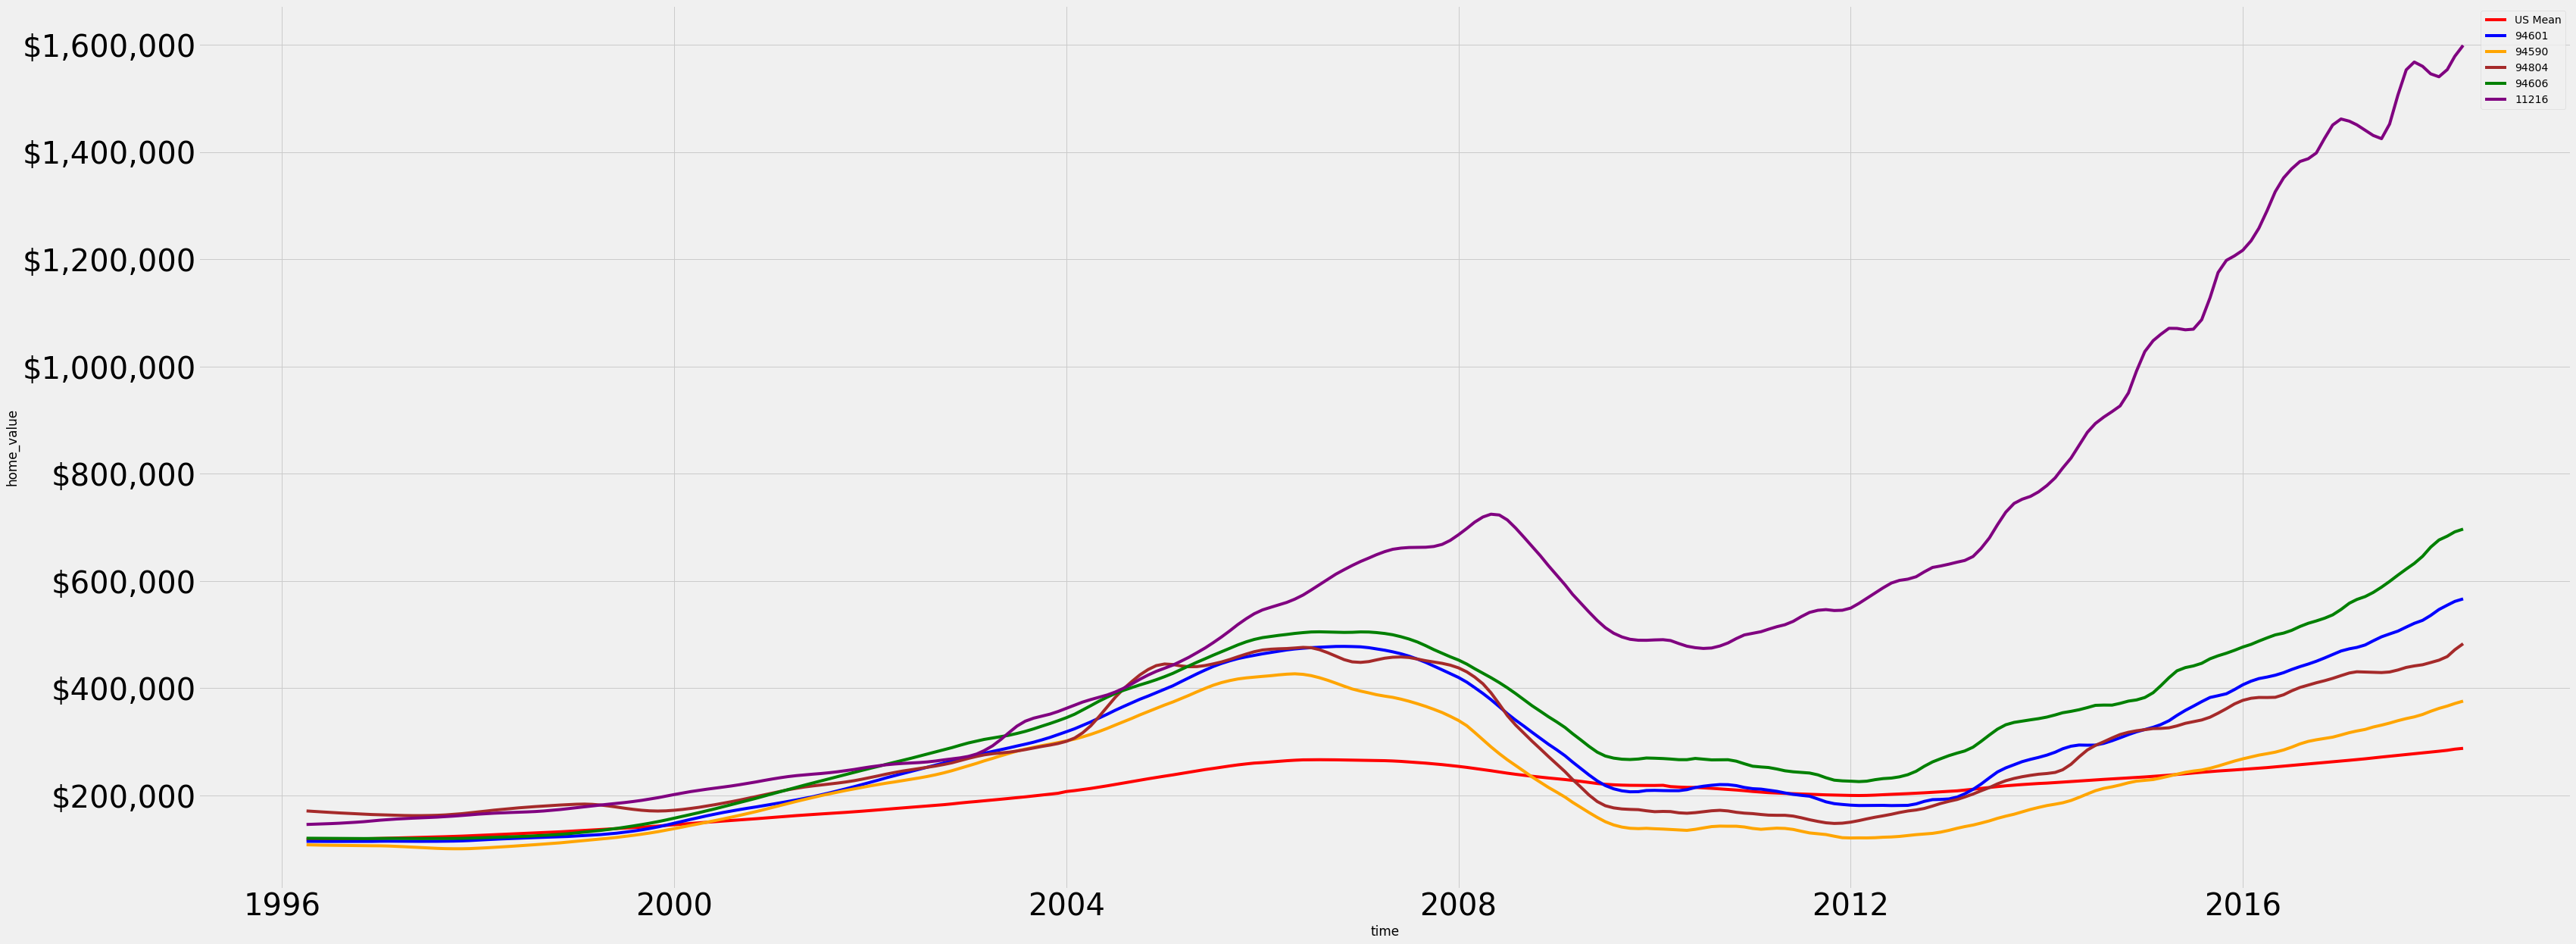

In [109]:
fig, ax = plt.subplots(figsize=(50, 20))

line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');
line2 = sns.lineplot(data=data_1, x='time', y='value', color='blue', label='94601');
line3 = sns.lineplot(data=data_2, x='time', y='value', color='orange', label='94590');
line4 = sns.lineplot(data=data_3, x='time', y='value', color='brown', label='94804');
line5 = sns.lineplot(data=data_4, x='time', y='value', color='green', label='94606');
line5 = sns.lineplot(data=data_5, x='time', y='value', color='purple', label='11216');

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

y1 = p.axvline('2008-01') #housing market crash begins
y2 = p.axvline('2012-01') #housing market crash ends
#ax.fill_between(y1, y2)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 


p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

## De-Trending Jon_Test

### Log

In [ ]:
jon_test_log = jon_test.copy()
jon_test_log['value'] = np.log(jon_test_log['value'])
jon_test_log.head()

In [ ]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
#dftest = adfuller(data['#Passengers'])
dftest = adfuller(jon_test_log)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

### Differencing

In [ ]:
# Difference your data
jon_diff = jon_test_log.diff(periods=12)

# Drop the missing values
jon_diff.dropna(inplace=True)

# Check out the first few rows
jon_diff.head(15)

In [ ]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
#dftest = adfuller(data['#Passengers'])
dftest = adfuller(jon_diff)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

# Removing Trends

In [ ]:
avg_home_ts.head()

In [ ]:
#code to quickly get log of values
#avg_home_ts['home_value']= np.log(avg_home_ts['home_value'])

In [ ]:
avg_home_ts.head()

### Taking Log of Data

In [ ]:
avg_home_ts_log = avg_home_ts.copy()
avg_home_ts_log['home_value'] = np.log(avg_home_ts['home_value'])
avg_home_ts_log.head()

In [ ]:
avg_home_ts_log.plot()

In [ ]:
fig, ax = plt.subplots(figsize=(50, 20))
#p = sns.lineplot(data=avg_home_ts, x='time', y='home_value', color='blue');
p = sns.lineplot(data=avg_home_ts_log, x='time', y='home_value', color='red');
p = sns.lineplot(data=avg_home_ts, x='time', y='home_value', color='blue', label='Original');

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

### Analysis: Taking the Log of the housing values helped detrend the data, but let's check the Dickey Fuller Test to verify.

In [ ]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
#dftest = adfuller(data['#Passengers'])
dftest = adfuller(avg_home_ts_log)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Analysis: p-value is still greater than .05, so I will continue to de-trend.

### Subtract Rolling Mean

In [ ]:
#data = avg_home_ts
data = avg_home_ts_log

roll_mean = data.rolling(window=4).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(data, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
data_minus_roll_mean = data - roll_mean
data_minus_roll_mean.head(15)

In [ ]:
data_minus_roll_mean.dropna(inplace=True)

In [ ]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [ ]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
#dftest = adfuller(data['#Passengers'])
dftest = adfuller(data_minus_roll_mean)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

### Analysis: p-value is .10. Getting Closer!

### Differencing

In [ ]:
# Difference your data
data_diff = data_minus_roll_mean.diff(periods=12)

# Drop the missing values
data_diff.dropna(inplace=True)

# Check out the first few rows
data_diff.head(15)

In [ ]:
#data_diff = avg_home_ts.diff(periods=12)

In [ ]:
#data_diff

In [ ]:
#data_diff = avg_home_ts.diff(periods=1)
#data_diff.head(10)

In [ ]:
#data_diff.dropna(inplace=True)

In [ ]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

In [ ]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
#dftest = adfuller(data['#Passengers'])
dftest = adfuller(data_diff)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

### Analysis: P-Value is now below threshold of .05, so I can assume that this time series is stationary and begin modeling!

## Visuals of Data.Diff

In [ ]:
fig, ax = plt.subplots(figsize=(50, 20))
p = sns.lineplot(data=avg_home_ts, x='time', y='home_value', color='blue');
p = sns.lineplot(data = data_diff, color='red',label='Data_diff')

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

In [ ]:
data_diff.hist(figsize = (12,6))
plt.show()

In [ ]:
data_diff.plot(kind='kde', figsize = (12,6))
plt.show()

## Recent Data
- only the data from 2013-2018

In [ ]:
ts.head()

In [ ]:
#recent_data = ts['2013':]
#recent_data.head()
recent_data = ts.iloc[:, -64:]

In [ ]:
recent_data.apply(lambda x: round(x, 2))

In [ ]:
recent_data['mean'] = recent_data.apply(lambda x: x.mean(), axis=1)

In [ ]:
recent_data['delta'] = recent_data.apply(lambda x: x['2018-04'] - x['2013-01'], axis=1)

In [ ]:
recent_data

# attempting melt

In [ ]:
test_data = new_df[new_df['ZipCode'] == ]

test_df = melt_data(test_data)
test_df.rename(columns={'value': 'value_1' }, inplace=True)

In [ ]:
data_60657 = ts[ts['ZipCode'] == '60657']
#data_80216 = ts[ts['RegionName'] == '80216']

In [ ]:
data_60657

In [ ]:
#data_60657.mean()

In [ ]:
test_df = melt_data(data_60657)

In [ ]:
test_df.rename(columns={'value': 'zip_60657'}, inplace=True)
test_df

In [ ]:
data_90210 = ts[ts['RegionName'] == '90210']

In [ ]:
data_90210

In [ ]:
melt_90210 = melt_data(data_90210)

In [ ]:
melt_90210

In [ ]:
melt_90210.rename(columns={'value': 'zip_90210'}, inplace=True)

In [ ]:
test_df['zip_90210'] = melt_90210['zip_90210']

In [ ]:
test_df

In [ ]:
test_df['1997']

In [ ]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
#dftest = adfuller(data['#Passengers'])
dftest = adfuller(test_df['zip_60657'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

## attempting merge

In [ ]:
#recent_stats = recent_data.iloc[:, -3:]

In [ ]:
new_df = ts.iloc[:, :7]
new_df = new_df.reset_index()

In [ ]:
new_df.head()

In [ ]:
#new_df.drop([:, -1])

In [ ]:
recent_data = recent_data.reset_index()

In [ ]:
recent_data.head()

In [ ]:
#cs_churn_df = cs_churn_df.merge(variable_1, on='#_of_calls')
new_df = new_df.merge(recent_data, on='index')

In [ ]:
new_df.head()

### ASSERT NEEDED: new_df has accurate data, but before turning in this project I should include ASSERT to prove that it is.

# Analysis of New DF w/Metrics

In [ ]:
new_df.drop(columns=['index'], inplace=True)

In [ ]:
new_df.head()

In [ ]:
new_df = new_df.sort_values('delta', ascending=False)

In [ ]:
new_df['delta_rank'] = range(len(ts))
new_df.head()

In [ ]:
new_df = new_df.sort_values('mean', ascending=False)
new_df['mean_rank'] = range(len(ts))
new_df.head()

In [ ]:
new_df.sort_values("delta_rank").head(1000)

# NEXT FEATURE = ADD DELTA AS A PERCENTAGE OF VALUE (IE, HOME VALUES INCREASED X%)

In [ ]:
new_df['delta_percent'] = new_df.apply(lambda x: x['delta'] / x['2013-01'], axis=1)

In [ ]:
#this seems to correct the percentages
#new_df['delta_percent'] = new_df['delta_percent'].diff() / new_df['delta_percent'].abs().shift()

In [ ]:
new_df.head()

In [ ]:
new_df.sort_values('delta_percent', ascending=False).head(100)

In [ ]:
new_df['delta'].isna().sum()

In [ ]:
#new_df.describe()

In [ ]:
new_df.sort_values('delta', ascending=False).head()

# Creating Analysis_DF

In [ ]:
new_df.head(2)

## Boston Values = Test of FillNa results

In [ ]:
new_df.sort_values('delta_percent', ascending=False).head()

In [ ]:
new_df.sort_values('City', ascending=True).head(1500)

In [ ]:
boston = new_df[new_df['City'] == 'Boston']
boston

In [ ]:
boston.iloc[0]

In [ ]:
new_df.iloc[:, -6:]

In [ ]:
analysis_df_5 = new_df.iloc[:, :8]
analysis_df_5.head()

In [ ]:
analysis_stats = new_df.iloc[:, -6:]
analysis_stats.head()

In [ ]:
analysis_df_5 = analysis_df_5.reset_index()
analysis_df_5

In [ ]:
analysis_stats = analysis_stats.reset_index()
analysis_stats.head(2)

In [ ]:
analysis_df_5 = analysis_df_5.merge(analysis_stats, on='index')
analysis_df_5.head(2)

In [ ]:
analysis_df_5.drop(columns=['index'], inplace=True)

## Analysis

In [ ]:
analysis_df_5.iloc[116]

In [ ]:
analysis_df_5.drop(columns='RegionID', inplace=True)

### Droping NaNs

Using Fillna()with Means may be distorting these results for a few areas.

In [ ]:
analysis_df_5.dropna(inplace=True)

# Top 20 Zips (based on RECENT historical data)

In [ ]:
#Top 20 Zips by percent increase.
analysis_df_5.sort_values('delta_percent', ascending=False).head(100)                                                            

In [ ]:
#Top 20 by Mean Home Values
analysis_df_5.sort_values('mean', ascending=False).head(10)  

In [ ]:
#Top 20 by delta 
analysis_df_5.sort_values('delta', ascending=False).head(10)  

## New York City

In [ ]:
#nyc_data = new_df[new_df['City'] == 'New York']
nyc_data = ts[ts['City'] == 'New York']

In [ ]:
nyc_data.head()

In [ ]:
nyc_data_scrubbed = nyc_data.drop(['RegionID', 'RegionName', 'City', 'State', 'CountyName', 'SizeRank',
#                                   'mean', 'delta','delta_rank', 'mean_rank', 'delta_percent'
                                  ], axis=1)

In [ ]:
nyc_mean = nyc_data_scrubbed.mean()

In [ ]:
nyc_mean_df = nyc_mean.reset_index()
nyc_mean_df['time'] = pd.to_datetime(nyc_mean_df['index'])
nyc_mean_df.set_index('time', inplace=True)
nyc_mean_df.rename(columns={0: 'home_value'}, inplace=True)
nyc_mean_df.drop(columns=('index'), inplace=True)

In [ ]:
nyc_mean_df.head()

In [ ]:
nyc_mean_df.plot();

In [ ]:
#nyc_10021 = df.drop(columns=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'])
#avg_home_df = avg_home_df.reset_index()
#avg_home_df['time'] = pd.to_datetime(avg_home_df['index'])
#avg_home_df.set_index('time', inplace=True)
#avg_home_df.rename(columns={0: 'home_value'}, inplace=True)
#avg_home_df.drop(columns=('index'), inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(50, 30))
p = sns.lineplot(data=nyc_mean_df, x='time', y='home_value', color='blue', label='NYC');
p = sns.lineplot(data=avg_home_ts, x='time', y='home_value', color='red', label='National Average');

p.set_xlabel("Date", fontsize = 25)
p.set_ylabel("Median Housing", fontsize = 25)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales: NYC vs National Mean", fontsize = 100)
plt.figsize=(50,25)

plt.show();

## Oakland CA

In [ ]:
oak_data = ts[ts['City'] == 'Oakland']

In [ ]:
oak_data

# Function

In [ ]:
def city_to_datetime(df):
    """
    Takes a city_df, returns datetime for the city with the mean home values of all records from that city
    """
    city = ts.drop(['RegionID', 'RegionName', 'City', 'State', 'CountyName',
                                 'SizeRank'], axis=1)
    city = city.mean()
    city = city.reset_index()
    city['time'] = pd.to_datetime(city['index'])
    city.set_index('time', inplace=True)
    city.rename(columns={0: 'home_value'}, inplace=True)
    city.drop(columns=('index'), inplace=True)
    return city

## Getting Datetime for Key Zipcodes

In [ ]:
data_80216 = ts[ts['RegionName'] == '80216']

In [ ]:
data_80216

In [ ]:
data_80216 = data_80216.drop(['RegionID', 'RegionName', 'City', 'State', 'CountyName',
                                'SizeRank'], axis=1)

In [ ]:
data_80216

In [ ]:
data_80216.reset_index()

In [ ]:
data_80216['time'] = pd.to_datetime(data_80216['index'])

In [ ]:
#oak_data = df[df['City'] == 'Oakland']
data_80216 = ts[ts['RegionName'] == '80216']

In [ ]:
data_80216_df = city_to_datetime(data_80216)

In [ ]:
data_80216_df

In [ ]:
df = ts.copy()

In [ ]:
df.head()

In [ ]:
# highest percent increase (2013 - 2018)
data_94601 = df[df['RegionName'] == '94601']
data_80216 = df[df['RegionName'] == '80216']
data_94590 = df[df['RegionName'] == '94590']
data_33460 = df[df['RegionName'] == '33460']
data_33705 = df[df['RegionName'] == '33705']
#highest value increase (2013 - 2018)
data_10021 = df[df['RegionName'] == '10021']
data_10011 = df[df['RegionName'] == '10011']
data_94027 = df[df['RegionName'] == '94027']
data_90210 = df[df['RegionName'] == '90210']
data_94301 = df[df['RegionName'] == '94301']

In [ ]:
data_94601_df = city_to_datetime(data_94601)
data_80216_df = city_to_datetime(data_80216)
data_94590_df = city_to_datetime(data_94590)
data_33460_df = city_to_datetime(data_33460)
data_33705_df = city_to_datetime(data_33705)

data_10021_df = city_to_datetime(data_10021)
data_10011_df = city_to_datetime(data_10011)
data_94027_df = city_to_datetime(data_94027)
data_90210_df = city_to_datetime(data_90210)
data_94301_df = city_to_datetime(data_94301)


## Visualization: 5 Top Zip Codes (delta value increase) vs National Average

In [ ]:
data_10011_df

In [ ]:
fig, ax = plt.subplots(figsize=(50, 30))

p = sns.lineplot(data=data_10021_df, x='time', y='home_value', color='green', label='10021');
p = sns.lineplot(data=data_10011_df, x='time', y='home_value', color='orange', label='10011');
p = sns.lineplot(data=data_94027_df, x='time', y='home_value', color='blue', label='94027');
p = sns.lineplot(data=data_90210_df, x='time', y='home_value', color='black', label='90210');
p = sns.lineplot(data=data_94301_df, x='time', y='home_value', color='brown', label='94301');


#p = sns.lineplot(data=avg_home_ts, x='time', y='home_value', color='red', label='National Average');

p.set_xlabel("Date", fontsize = 25)
p.set_ylabel("Median Housing", fontsize = 25)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales: Selected Zip Codes vs National Mean", fontsize = 100)
plt.figsize=(50,25)

plt.legend(loc='best', prop={'size': 30})

plt.show();

## Visualization: 5 Top Zip Codes (delta percentage increase) vs National Average

In [ ]:
fig, ax = plt.subplots(figsize=(50, 30))

p = sns.lineplot(data=data_94601_df, x='time', y='home_value', color='green', label='94601');
p = sns.lineplot(data=data_80216_df, x='time', y='home_value', color='orange', label='80216');
p = sns.lineplot(data=data_94590_df, x='time', y='home_value', color='blue', label='94590');
p = sns.lineplot(data=data_33460_df, x='time', y='home_value', color='black', label='33460');
p = sns.lineplot(data=data_33705_df, x='time', y='home_value', color='brown', label='33705');


p = sns.lineplot(data=avg_home_ts, x='time', y='home_value', color='red', label='National Average');

p.set_xlabel("Date", fontsize = 25)
p.set_ylabel("Median Housing", fontsize = 25)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales: Selected Zip Codes vs National Mean", fontsize = 100)
plt.figsize=(50,25)

plt.legend(loc='best', prop={'size': 30})

plt.show();

In [ ]:
data_10011_df

# Master Visualization: City Home Values vs National Average

In [ ]:
fig, ax = plt.subplots(figsize=(50, 30))

p = sns.lineplot(data=data_80216_df, x='time', y='home_value', color='green', label='80216');
p = sns.lineplot(data=nyc_mean_df, x='time', y='home_value', color='blue', label='NYC');
#p = sns.lineplot(data=oak_data_mean_df, x='time', y='home_value', color='black', label='Oakland');
p = sns.lineplot(data=avg_home_ts, x='time', y='home_value', color='red', label='National Average');

p.set_xlabel("Date", fontsize = 25)
p.set_ylabel("Median Housing", fontsize = 25)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales: Selected Cities vs National Mean", fontsize = 100)
plt.figsize=(50,25)

plt.show();

# Testing Grouper

In [ ]:
#year_groups = avg_home_df.groupby(pd.Grouper(freq ='A'))

In [ ]:
year_groups.mean()

## State Analysis

In [ ]:
#shows the mean home value for years 2013-apr 2018 by state
# RegionID, SizeRank, deltaRank, mean_rank are all messed up.
state_analysis_df_5 = analysis_df_5.groupby('State').mean().sort_values('delta_percent', ascending=False)
state_analysis_df_5

In [ ]:
# Dropping RegionID, SizeRank, deltaRank, mean_rank as they are all messed up.
state_analysis_df_5.drop(columns=['SizeRank', 'delta_rank', 'mean_rank'], inplace=True)

In [ ]:
state_analysis_df_5 = state_analysis_df_5.reset_index()

In [ ]:
#mean, etc
state_analysis_df_5.describe()

## Analysis
- Avg(Mean) Home Value in 2013-01: 199,231
- Avg(Mean) Home Value in 2018-04: 264,644
- Mean of 5 year date range: 228,937
- Avg Delta by price = 65,412
- Av delta increase = 32% (or .32)

### Top 10 States

In [ ]:
#Top 10 States by %Increase in Home Value
state_analysis_df_5.sort_values('delta_percent', ascending=False).head(10)

In [ ]:
#Top 10 States by Mean Home Value
state_analysis_df_5.sort_values('mean', ascending=False).head(10)

In [ ]:
#Top 10 States by Delta ammount increase
state_analysis_df_5.sort_values('delta', ascending=False).head(10)

# Archive (5/4)

## Grouping By State

In [ ]:
#recent_data.groupby('genres_list')['production_budget'].describe().sort_values('mean', ascending=False)
state_df = df.groupby('State')
state_df = state_df.mean() # Getting the mean value for each month
state_df.drop(columns=['RegionID', 'SizeRank'], axis=1, inplace=True)
state_df.head()

## Using Virginia as an example to figure out the process

In [ ]:
va_df = state_df.iloc[45]
va_df = va_df.reset_index()
va_df.rename(columns={"index": "Date", "VA": "home_sales"}, inplace=True)
va_df['Date'] = pd.to_datetime(va_df['Date'])
va_df['home_sales'] = va_df['home_sales'].apply(lambda x: float("{:.2f}".format(x)))
va_df = va_df.set_index('Date')

In [ ]:
va_df.head()

## Visualization

In [ ]:
fig, ax = plt.subplots(figsize=(50, 20))
p = sns.lineplot(data=va_df, x='Date', y='home_sales', color='blue');

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales in Virginia by Year", fontsize = 100)
plt.figsize=(50,25)

plt.show();

### Histogram (needs work)

In [ ]:
va_df.hist(figsize = (12,6))
plt.show()

### Density Plot

In [ ]:
va_df.plot(kind='kde', figsize = (12,6))
plt.show()

In [ ]:
# Determine rolling statistics
roll_mean = va_df.rolling(window=12, center=False).mean()
roll_std = va_df.rolling(window=12, center=False).std()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
p = sns.lineplot(data=va_df, x='Date', y='home_sales', color='blue', label='Original');
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales in Virginia by Year", fontsize = 100)
plt.figsize=(50,25)
plt.legend(loc='best')

plt.show();

## Analysis:
- Mean increases over time and therefore is not stationary

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

## Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

### Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

## Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


## Step 1: Load the Data/Filtering for Chosen Zipcodes

## Step 2: Data Preprocessing

In [ ]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

## Step 3: EDA and Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

## Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

## Step 5: ARIMA Modeling

## Step 6: Interpreting Results